# SSD Jet Detection Evaluation


In [1]:
# Import GPU libs

import setGPU
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

setGPU: Setting GPU to: 0


In [2]:
# Other imports

import numpy as np
import pandas as pd
import simplejson as json

In [3]:
# Set presentation settings

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tick

from matplotlib import cm
from matplotlib.colors import SymLogNorm
from mpl_toolkits import mplot3d

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 6.0)

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Anonymous Pro for Powerline']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 16
matplotlib.rcParams["axes.titlesize"] = 14

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

with open('../data/palette.json') as json_file:
    color_palette = json.load(json_file)

In [4]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
from keras import backend as K
from keras.models import load_model

from ssd.average_precision_evaluator import Evaluator
from ssd.generator import DataGenerator
from ssd.keras_ssd7 import build_model
from ssd.keras_ssd_loss import SSDLoss
from ssd.layers.keras_layer_AnchorBoxes import AnchorBoxes
from ssd.layers.keras_layer_DecodeDetections import DecodeDetections
from ssd.layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from ssd.layers.keras_layer_L2Normalization import L2Normalization

Using TensorFlow backend.


In [6]:
# Model configuration parameters

SAVE_PATH = '/data/adpol'
MODEL_NAME = 'ceva-cms-jet-ssd'
DATA_SOURCE = '/eos/user/a/adpol/ceva'
SPLIT = [0.1, 0.1, 0.1]
MAX_EVENTS = 100

classes = ['background', 'b', 'h', 'W', 't', 'q']

img_height = 452 # Pixel height
img_width = 340 # Pixel width
img_channels = 1 # Number of channels
n_classes = 4 # Number of target classes

# Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_mean = None 
intensity_range = None

# An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
scales = [0.16, 0.4, 0.6, 0.8, 0.96]
# The list of aspect ratios for the anchor boxes
aspect_ratios = [1.0]
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = True # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

In [7]:
# Compile the model

K.clear_session()

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='inference',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range,
                    confidence_thresh=0.7, iou_threshold=0.5, top_k=10)

# Load model
model.load_weights('%s/%s.h5' % (SAVE_PATH, MODEL_NAME), by_name=True)

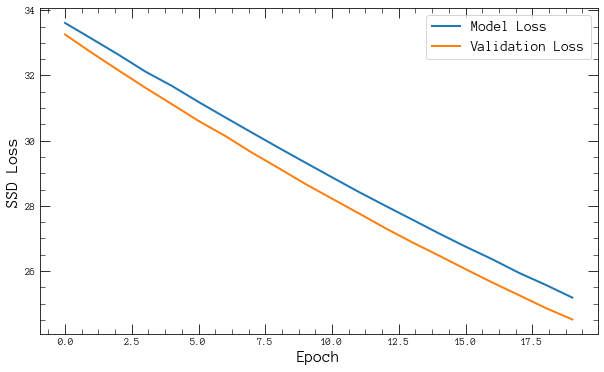

In [8]:
# Show loss function

log_data = pd.read_csv('%s/%s.csv' % (SAVE_PATH, MODEL_NAME),
                       sep=',',
                       engine='python')

plt.figure(figsize=(10,6))
plt.plot(log_data['loss'], label='Model Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.ylabel('SSD Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right', prop={'size': 14});

# plt.savefig("ssd-loss.png", bbox_inches="tight")

In [9]:
# Testing data generator

hdf5_dataset_paths_list = []

for i in np.arange(8, 9):
    for j in ['bb', 'tt', 'WW', 'hh']:
        hdf5_dataset_paths_list.append('/eos/user/a/adpol/ceva/RSGraviton_%s_NARROW_%s.h5' % (j, i))

test_dataset = DataGenerator(hdf5_dataset_paths=hdf5_dataset_paths_list, max_size=MAX_EVENTS)

In [10]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=test_dataset,
                      model_mode='inference')

In [11]:
results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=100,
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='integrate',
                    num_recall_points=11,
                    verbose=True)

Number of histograms in the evaluation dataset: 400
Generating predictions: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]
Computing the number of positive ground truth boxes per class.
Matching predictions to ground truth, class 1/4.
Matching predictions to ground truth, class 2/4.
Matching predictions to ground truth, class 3/4.
Matching predictions to ground truth, class 4/4.
Computing precisions and recalls, class 1/4
Computing precisions and recalls, class 2/4
Computing precisions and recalls, class 3/4
Computing precisions and recalls, class 4/4
Computing average precision, class 1/4
Computing average precision, class 2/4
Computing average precision, class 3/4
Computing average precision, class 4/4


In [12]:
mean_average_precision, average_precisions, precisions, recalls = results

In [13]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

b             AP    0.0
h             AP    0.0
W             AP    0.0
t             AP    0.0

              mAP   0.0


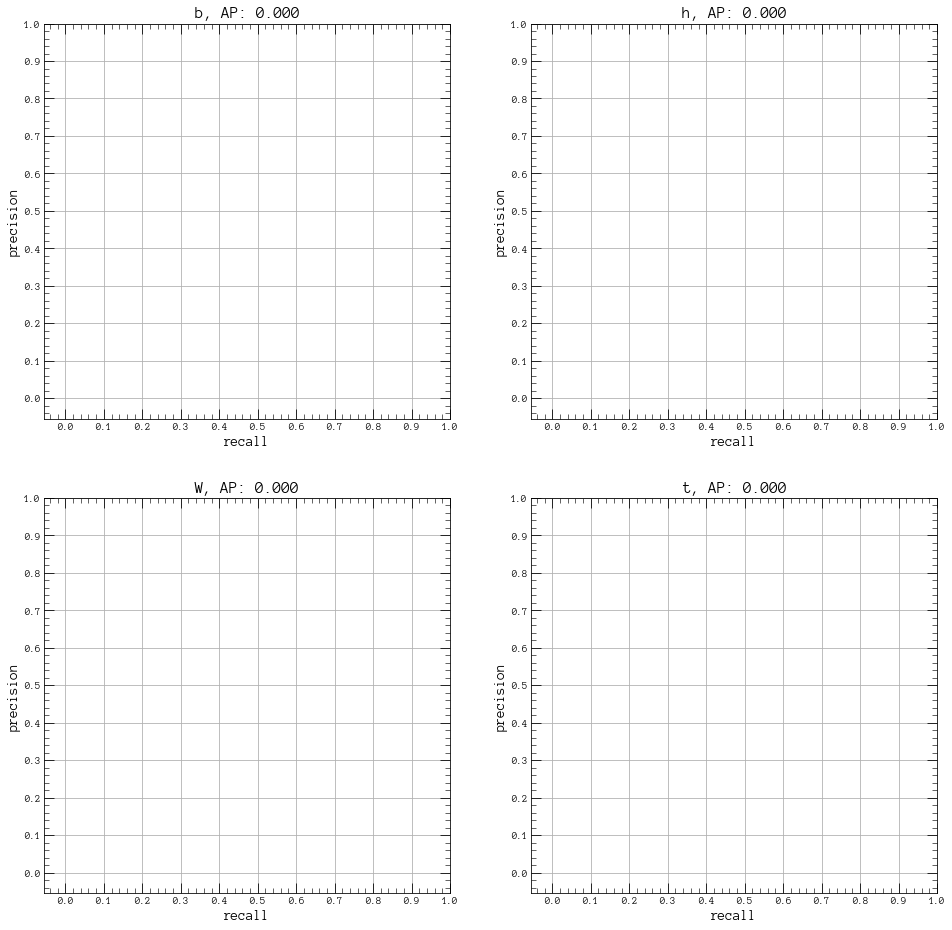

In [14]:
m = max((n_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)